# Shifted-tilted Tophat at Gaussian interference 0 um shift

Applying first-order shift,tilt to tophat, integrate with HG00



\begin{align*}
\sum_{n,m} u_{n,m} \rightarrow 
	\sum_{n,m} 
	\lbrace &
		u_{n+2,m}[ X_+^2
		(-i\frac{2ka\alpha}{w^2} 
			+ \frac{a\alpha 2k^2}{R_c} 
			)]
		\\+&
		u_{n+1,m}
			[ X_+^1(ik\alpha 
			- \frac{2a}{w^2} 
			- a \frac{ik}{R_c})
			]
		\\+&
		u_{n,m} 
			[1
			+X_+^1
			(ik\alpha \frac{2a\sqrt{n}}{w} e^{i\Psi} )
			+ X_0^2 ( 
			\frac{a\alpha 2k^2}{R_c} 
			- i\frac{2ka\alpha}{w^2}
			)
			]
		\\+&
		u_{n-1,m} 
			[
		\frac{2a\sqrt{n}}{w} e^{i\Psi} 
			+ 	X_-^1(
				ik\alpha 
				- \frac{2a}{w^2}
		 		- a \frac{ik}{R_c}
		 		)
		 	]
		\\+&
		u_{n-2,m} 
		[ X_-^1(
		ik\alpha a\frac{2\sqrt{n}}{w}e^{i\Psi}
		) 
		+ X_-^2 (
			 \frac{a\alpha 2k^2}{R_c} 
			-i\frac{2ka\alpha}{w^2}
		)
		] 	
	\rbrace
\end{align*}


In [1]:
import PauLisa as pl, PL_Plot as plplt,plback as plb, Tophat_integration_AW as th, numpy as np, matplotlib.pyplot as plt, cmath as cm
from Signals import *

from numpy import pi as pi
from numpy import angle
from math import e
from numpy import sqrt as sqrt
from scipy.special import erf as erf
import mpmath as mp
import scipy.io

from math import pi, log, exp, sin, cos, atan, e, radians, degrees
from scipy.special import gamma as gamma
from scipy.special import erf as erf
from math import factorial as fact
import cmath
from cmath import sqrt as sqrt
import numpy as np

from time import process_time

inf=np.inf

import pandas as pd
from pprint import pprint


## Tophat coeffients from AW

In [2]:
# mat = scipy.io.loadmat('Top_hat_for_paul.mat')
mat = scipy.io.loadmat('paul_coef_file.mat')
for x in mat:
  print(x)
coef=mat['coeftopUnitInt'].ravel()
print(mat['readmepaul'])
# coef=mat['coeftop'].ravel()

def N_f(A):
    
    res = np.floor((np.sqrt(8*A+1)-1)/2)
    
    #res = (np.sqrt(9+8*A)-3)/2
    return(res)

def m(N,A):
    res = (N+1)*(N+2)/2 - (A+1)
    return(res)

#def n(N,A):
#    m= (N+1)*(N+2)/2 - (A+1)
#    res = N-m
#    return(res)
def n(N,A):
    res = A - (N*(N+1)/2)
    return(res)

NumberModes = int(len(coef))
listModesN = [None] * NumberModes
listModesM = [None] * NumberModes
listModesC = [None] * NumberModes

area = pi*1e-3**2

#for i in range(len(coef)):
#    A=i
#    N= N_f(A)
#
#    if (m(N,A)%2 == 0) & (n(N,A)%2 == 0):
#        print(coef[A], '\t\t\t' , m(N,A), ',' , n(N,A))

for i in range(NumberModes):
    A=i
    N= N_f(A)
    listModesN[i] = int(m(N,A))
    listModesM[i] = int(n(N,A))
    listModesC[i] = coef[i]
    
    

__header__
__version__
__globals__
coeftopUnitInt
coeftopUnitPow
readmepaul
['Two tophat coefficient variables, one for unit power and one for \n unit intensity, should be clear from the name which is which.\nAgain these assume a waist 1/3 of a mm.']


In [3]:


modes = pl.create_modes(listModesM,listModesN,listModesC,NumberModes)

N=28 # mode order
modes_N= pl.create_modes_orderN(listModesM,listModesN,listModesC,NumberModes,N)




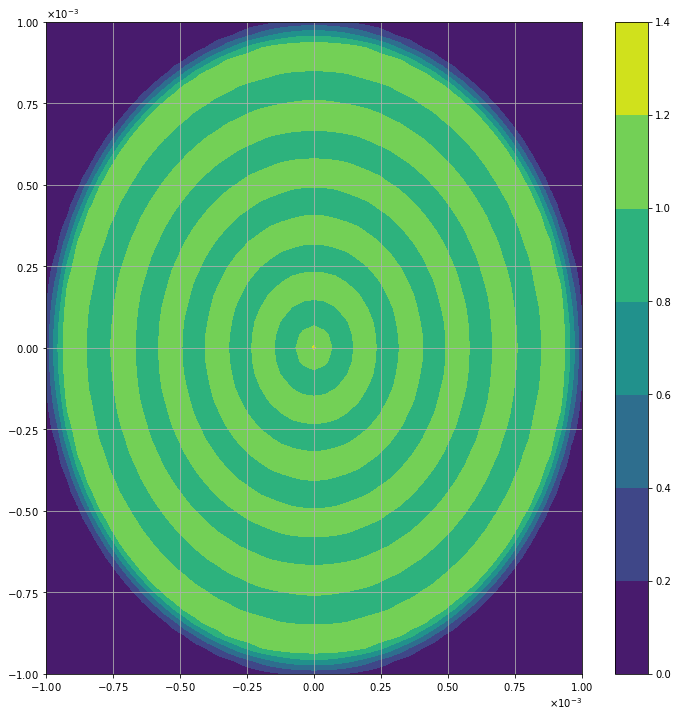

In [4]:
waist = (1/3)*1e-3
params = pl.Params(1064e-9,waist,0)
plane = pl.Plane(-2e-3,2e-3,101,-2e-3,2e-3,101)

calc=pl.calculate(params,plane,modes,0)
#plot
fig, ax = plt.subplots(figsize=(12, 12))
cs = plt.contourf(calc.plane.getX(), calc.plane.getY(), abs(calc.getAmp() ** 2))

ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0), useMathText=True)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText=True)

plt.xlim([-1e-3,1e-3])
plt.ylim([-1e-3,1e-3])

cbar = fig.colorbar(cs)

plt.grid()

## Integration for signals

In [5]:
#loop through and sum over modes overlap where a,b -> n,m
def iterate_modes_overlap(w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1,x_2,Z,Y,modes):   

    N = len(modes)
    M = len(modes[0])
    res_arr = [[0 for i in range(10)] for j in range(10)]
    res = 0

    for a in range(N):
        for b in range(M):            
            #ignore zero coeff.
            if (modes[a][b]!=0):
                c_nm = modes[a][b]
                #result is the sum of all overlap coefficients each with a factor of mode coefficient
                res += ( c_nm * th.overlap(a,b,w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1,x_2,Z,Y) )
                
    return(res)

In [6]:
def signals(v):
    #points determine size of arrays (equivalent to # data points plotted)
    points = v.points
    time_start = process_time()

    time_ave = 0

    #modes_arr = [0]*points
    cl = [0]*points
    cr = [0]*points
    phi_l = [0]*points
    phi_r = [0]*points
    dws = [0]*points
    lps = [0]*points
    total_lps = [0]*points


    #alpha_arr = np.linspace(-500e-6,500e-6,points)

    for p in range (points):
        time_ave_start = process_time()
        #shift x+zsina
        new_modes = rotate_LO(v.z,v.params,v.a,v.alpha_arr[p],modes)
        
        #create arrays of overlap coefficients left and right
        cl[p] = iterate_modes_overlap(v.w_1,v.w_2,v.zR_1,v.zR_2,v.k_1,v.k_2,v.d_1,v.W_2,v.x_1L,v.x_2L,v.Z,v.Y,new_modes) # left overlap (-2e-3,0)

        cr[p] = iterate_modes_overlap(v.w_1,v.w_2,v.zR_1,v.zR_2,v.k_1,v.k_2,v.d_1,v.W_2,v.x_1R,v.x_2R,v.Z,v.Y,new_modes) # right overlap (0,2e-3)
        time_ave += (process_time()-time_ave_start)

        #create arrays of phases for left and right coeff.
        phi_r[p]=angle(cr[p])
        phi_l[p]=angle(cl[p])
        
        #create arrays of dws &lps for phases in phase arrays
        dws[p] = (phi_r[p]-phi_l[p])
        lps[p] = 0.5*(phi_r[p]+phi_l[p])/v.k_1*1e3
#         total_lps[p] = (phi_r[p]+phi_l[p])/v.k_1*1e3
        total_lps[p] = angle(cr[p]+cl[p])/v.k_1*1e3
    #total time for all DWS & LPS points (not including scattering)
    time_elapsed = (process_time() - time_start)
    print(time_elapsed,'s')
    print(time_ave/p,'s')
    
    return(dws,lps,total_lps)

In [9]:
num=101

class Vars:
#modes,alpha with points
    def __init__(self, 
                 lam=1064e-9,
                 z_PD=0,z=0,
                 z_m=0,Z=0,
                 z_LO=0, d_1=0,
                 Y=20e-3,
                 x_1R=10e-6,x_2R=20e-3,
                 x_1L=-20e-3,x_2L=-10e-6,
                 w_1=1e-3, w_2=waist,
                 zR_1=pi*1e-3**2/1064e-9,zR_2=pi*waist**2/1064e-9,
                 k_1=5905249.348852994,k_2=5905249.348852994,
                 params=pl.Params(1064e-9,waist,0),
                 W_2=1,
                 points=num,
                 a=-0e-6,alpha_arr=np.linspace(-500e-6,500e-6,num),modes_arr=[0]*num):
        self.lam = lam


        self.z_PD = z_PD #PD location
        self.z = z #prop distance assumed PD

        self.z_m = z_m #meas beam 
        self.Z = Z #distance PD-m

        self.z_LO = z_LO #Local ref. beam
        self.d_1 = d_1 #distance PD-LO


        self.Y = Y #Y int bound

        self.x_1R = x_1R
        self.x_2R = x_2R 

        self.x_1L = x_1L #assumed symmetric with right side
        self.x_2L = x_2L

        self.w_1 = w_1 #waist LO 
        self.w_2 = w_2 #waist MS

        self.zR_1 = zR_1 #rayleigh LO
        self.zR_2 = zR_2


        self.k_1 = k_1 #wavenum LO
        self.k_2 = k_2

        self.params = params #for building tophat coefficients

        self.W_2 = pl.w(z,pl.Params(1064e-9,waist,0)) #tophat beam rad , w(z) or 1e-3?



        #integration and misalignment
        self.points = points

        self.a = a
        self.alpha_arr = alpha_arr

        self.modes_arr = modes_arr

        #build modes from misalignments
        for p in range (points):
            self.modes_arr[p] = rotate_LO(z,params,a,alpha_arr[p],modes) #array of array of scattered modes#array of array of scattered modes

    def setz(self,z):
        self.z = z #prop distance assumed PD
        self.z_PD = z #PD location
        
        self.Z = z-self.z_m #distance PD-m

        self.d_1 = self.z_PD-self.z_LO #distance PD-LO
    
        self.W_2 = pl.w(z,pl.Params(1064e-9,waist,0))
        
        #scattering also depends on z...
        for p in range (self.points):
            self.modes_arr[p] = [0]*p #clear modes
            self.modes_arr[p] = rotate_LO(self.z,self.params,self.a,self.alpha_arr[p],modes) #array of array of scattered modes#array of array of scattered modes

        



## Defaults

In [10]:
v = Vars()

####################################################

a_arr = [10e-6,0,-10e-6]

dws_arr = [0]*len(a_arr)
lps_arr = [0]*len(a_arr)
total_lps_arr = [0]*len(a_arr)
dws_slope_arr = [0]*len(a_arr)
lps_slope_arr = [0]*len(a_arr)
total_lps_slope_arr = [0]*len(a_arr)

for i in range(len(a_arr)):
    v.a= a_arr[i]
    dws,lps,total_lps = signals(v)

    dws_arr[i] = dws
    lps_arr[i] = lps
    total_lps_arr[i] = total_lps
    
    dws_slope = np.zeros(len(dws),np.float)
    dws_slope[0:-1] = np.diff(dws)/np.diff(v.alpha_arr)
    dws_slope[-1] = (dws[-1] - dws[-2])/(v.alpha_arr[-1] - v.alpha_arr[-2])
    lps_slope = np.zeros(len(lps),np.float)
    lps_slope[0:-1] = np.diff(lps)/np.diff(v.alpha_arr)
    lps_slope[-1] = (lps[-1] - lps[-2])/(v.alpha_arr[-1] - v.alpha_arr[-2])
    total_lps_slope = np.zeros(len(total_lps),np.float)
    total_lps_slope[0:-1] = np.diff(total_lps)/np.diff(v.alpha_arr)
    total_lps_slope[-1] = (total_lps[-1] - total_lps[-2])/(v.alpha_arr[-1] - v.alpha_arr[-2])
    
    dws_slope_arr[i] = dws_slope
    lps_slope_arr[i] = lps_slope
    total_lps_slope_arr[i] = total_lps_slope
    

###############################################
off = [-10e-6,0,10e-6]
p = 'pi'
descript = 'Tophat with perfect imaging. Results are ordered -10um,0,10um. 101 points'

scipy.io.savemat('paul_TH_perfimag_LO.mat', mdict={'lps_TH'+p: lps_arr, 'total_lps_TH'+p: total_lps_arr,'dws_TH'+p: dws_arr,
                                         'lps_slope_TH'+p: lps_slope_arr, 'total_lps_slope_TH'+p : total_lps_slope_arr,
                                        'dws_slope_TH'+p: dws_slope_arr, 'offset'+p : off, 'description' : descript })



104.765625 s
1.04765625 s
80.78125 s
0.8078125 s
94.125 s
0.94125 s


10.21875 s
1.021875 s
10.25 s
1.025 s
11.265625 s
1.1265625 s
10.078125 s
1.0078125 s
10.15625 s
1.015625 s
9.5 s
0.95 s


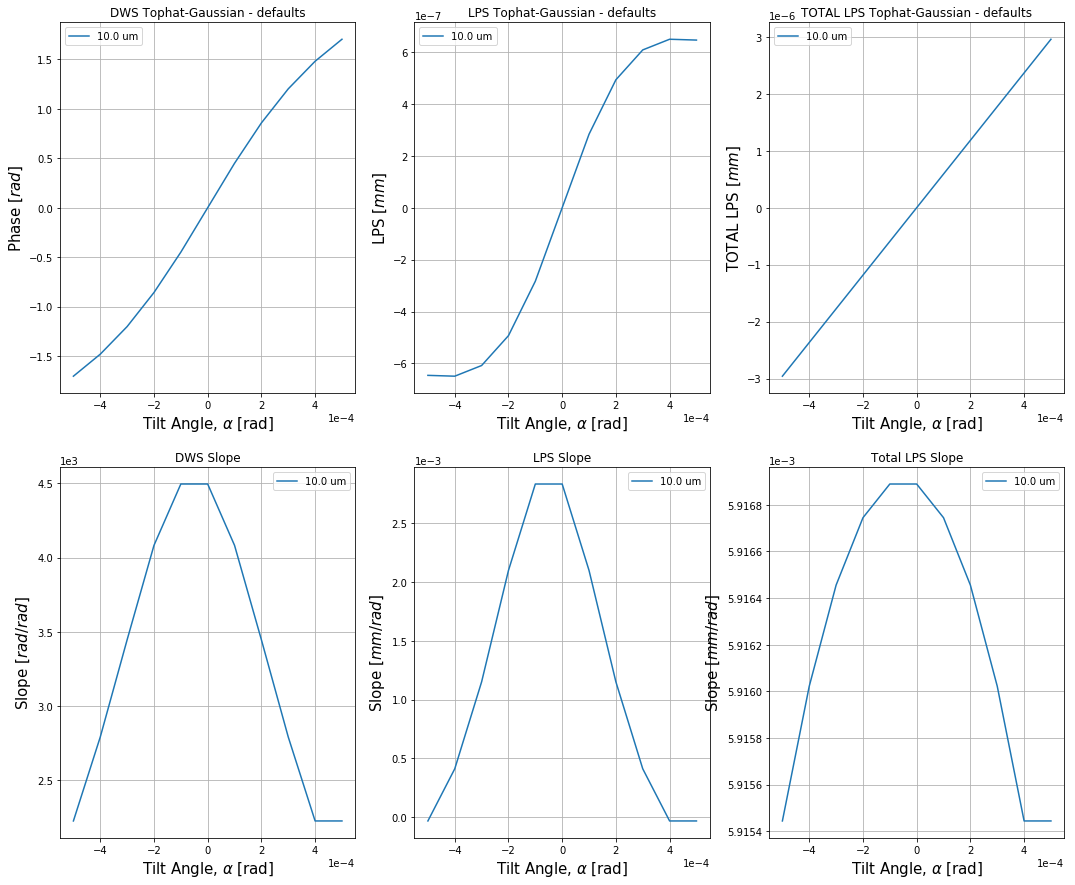

In [8]:
v = Vars()

##############################################
#plt.savefig("5-4_HG00_lps.png")
plt.figure(figsize=(18,15))
plt.subplot(231)

a_arr = [-10e-6]

for i in a_arr:
    v.a= i
    dws,lps,total_lps = signals(v)
    plt.plot(v.alpha_arr, dws,label = str(i*-1e6) + ' um')


plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Phase $[' +  'rad]$', fontsize=15) 
plt.title(r'DWS Tophat-Gaussian - defaults') 
# plt.xlim([-200e-6,200e-6])
plt.legend()


plt.grid()

#plt.savefig("5-4_HG00_lps.png")
###############################################
##############################################
#plt.savefig("5-4_HG00_lps.png")
plt.subplot(232)


for i in a_arr:
    v.a= i
    dws,lps,total_lps = signals(v)
    plt.plot(v.alpha_arr, lps,label = str(i*-1e6) + ' um')


plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'LPS $[' +  'mm]$', fontsize=15) 
plt.title(r'LPS Tophat-Gaussian - defaults') 
# plt.xlim([-200e-6,200e-6])
plt.legend()

plt.grid()

#plt.savefig("5-4_HG00_lps.png")
###############################################
#plt.savefig("5-4_HG00_lps.png")
plt.subplot(233)

dws_slope = [0]*len(dws)
lps_slope = [0]*len(lps)
total_lps_slope = [0]*len(total_lps)

for i in a_arr:
    v.a= i
    dws,lps,total_lps = signals(v)
    plt.plot(v.alpha_arr, total_lps,label = str(i*-1e6) + ' um')
    
    dws_slope = np.diff(dws) / np.diff(v.alpha_arr)
    lps_slope = np.diff(lps) / np.diff(v.alpha_arr)
    total_lps_slope = np.diff(total_lps) / np.diff(v.alpha_arr)
    alpha2 = (v.alpha_arr[:-1] + v.alpha_arr[1:]) / 2

plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'TOTAL LPS $[' +  'mm]$', fontsize=15) 
plt.title(r'TOTAL LPS Tophat-Gaussian - defaults') 
# plt.xlim([-200e-6,200e-6])
plt.legend()

plt.grid()
####################################################

# #plt.savefig("5-4_HG00_lps.png")
# plt.figure(figsize=(9,6))

# dws_slope = [0]*len(dws)
# lps_slope = [0]*len(lps)
# total_lps_slope = [0]*len(total_lps)

# for i in a_arr:
#     v.a= i
#     dws,lps,total_lps = signals(v)
    
    
#     dws_slope = np.diff(dws) / np.diff(v.alpha_arr)
#     lps_slope = np.diff(lps) / np.diff(v.alpha_arr)
#     total_lps_slope = np.diff(total_lps) / np.diff(v.alpha_arr)
#     alpha2 = (v.alpha_arr[:-1] + v.alpha_arr[1:]) / 2
    
#     plt.plot(alpha2, lps_slope)
    
# plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# plt.ylabel(r'LPS $[' +  'mm]$', fontsize=15) 
# plt.title(r'LPS Slope') 
# # plt.xlim([-200e-6,200e-6])


# plt.grid()
####################################################

###############################################
#plt.savefig("5-4_HG00_lps.png")
plt.subplot(234)

dws_slope = [0]*len(dws)
lps_slope = [0]*len(lps)
total_lps_slope = [0]*len(total_lps)

for i in a_arr:
    v.a= i
    dws,lps,total_lps = signals(v)
    

    dws_slope = np.zeros(len(dws),np.float)
    dws_slope[0:-1] = np.diff(dws)/np.diff(v.alpha_arr)
    dws_slope[-1] = (dws[-1] - dws[-2])/(v.alpha_arr[-1] - v.alpha_arr[-2])

    plt.plot(v.alpha_arr, dws_slope, label = str(i*-1e6) + ' um')
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Slope $[' +  'rad/rad]$', fontsize=15) 
plt.title(r'DWS Slope') 
# plt.xlim([-200e-6,200e-6])
plt.legend()

plt.grid()
####################################################

###############################################
#plt.savefig("5-4_HG00_lps.png")
plt.subplot(235)

dws_slope = [0]*len(dws)
lps_slope = [0]*len(lps)
total_lps_slope = [0]*len(total_lps)

for i in a_arr:
    v.a= i
    dws,lps,total_lps = signals(v)

    lps_slope = np.zeros(len(lps),np.float)
    lps_slope[0:-1] = np.diff(lps)/np.diff(v.alpha_arr)
    lps_slope[-1] = (lps[-1] - lps[-2])/(v.alpha_arr[-1] - v.alpha_arr[-2])

    plt.plot(v.alpha_arr, lps_slope, label = str(i*-1e6) + ' um')
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Slope $[' +  'mm/rad]$', fontsize=15) 
plt.title(r'LPS Slope') 
# plt.xlim([-200e-6,200e-6])
plt.legend()

plt.grid()
####################################################

#plt.savefig("5-4_HG00_lps.png")
plt.subplot(236)

dws_slope = [0]*len(dws)
lps_slope = [0]*len(lps)
total_lps_slope = [0]*len(total_lps)

for i in a_arr:
    v.a= i
    dws,lps,total_lps = signals(v)

    total_lps_slope = np.zeros(len(total_lps),np.float)
    total_lps_slope[0:-1] = np.diff(total_lps)/np.diff(v.alpha_arr)
    total_lps_slope[-1] = (total_lps[-1] - total_lps[-2])/(v.alpha_arr[-1] - v.alpha_arr[-2])

    plt.plot(v.alpha_arr, total_lps_slope, label = str(i*-1e6) + ' um')
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Slope $[' +  'mm/rad]$', fontsize=15) 
plt.title(r'Total LPS Slope') 
# plt.xlim([-200e-6,200e-6])
plt.legend()

plt.grid()

# plt.savefig('perf_imaging_2.pdf')